# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

**Цель**: построить модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

**Задачи**:

- Провести исследовательский анализ данных.
- Полдготовить данные к обучению
- Обучить нейронную сеть и рассчитайте её качество. Добиться значения MAE на тестовой выборке не больше 8.

## Исследовательский анализ данных

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications.resnet import ResNet50

Загрузим данные в проект. Используем ImageDataGenerator как инструмент для доступа к потоку фотографий.

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

datagen = ImageDataGenerator(rescale=1./255)
gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


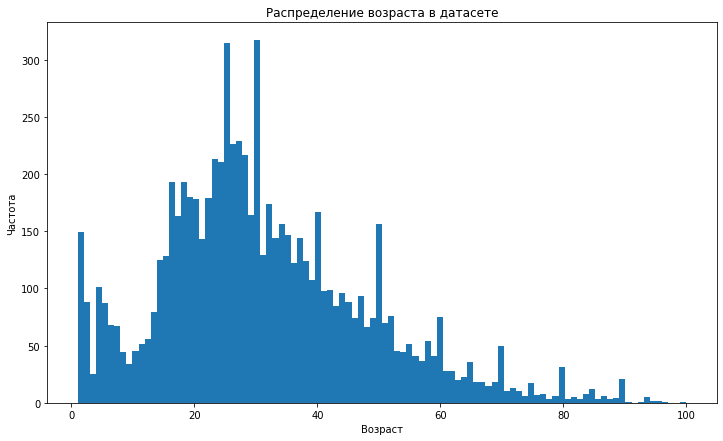

In [4]:
plt.figure(figsize=(12, 7))
plt.hist(labels['real_age'], bins=100)
plt.title('Распределение возраста в датасете')
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.show()

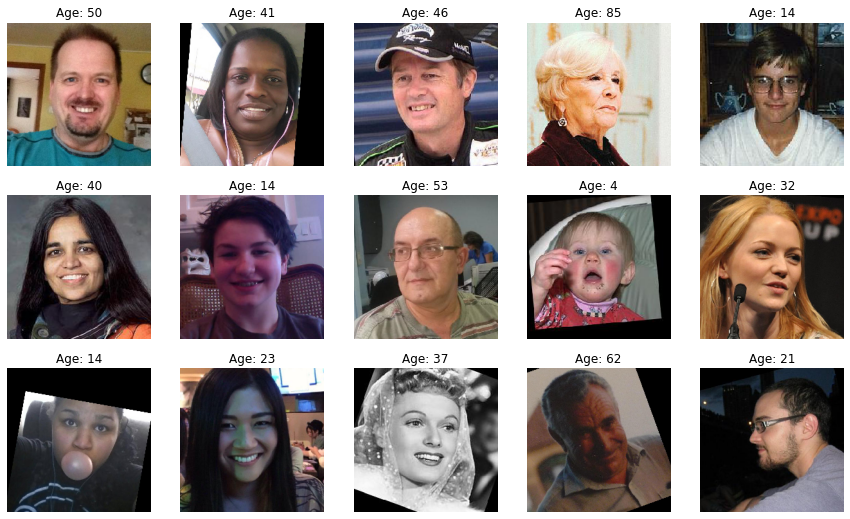

In [5]:
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
images, ages = next(gen_flow)

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.set_title(f"Age: {ages[i]}")
    ax.axis('off')

plt.show()

**Выводы**: 
- В датасете labels.csv содержится информация о 7591 объекте. Это может оказаться мало для обучения нейронной сети с нуля, поэтому мы будем использовать предобученную нейронную сеть. 
- Есть смещение в распределении возрастов — большинство примеров относятся к людям в возрасте от 20 до 40 лет. Это может привести к тому, что модель будет лучше обучаться на примерах из этого возрастного диапазона, но может показывать худшие результаты на других возрастных группах.
- Датасет содержит фотографии людей различного возраста и пола, а также и люди разных возрастов при разных условиях съемки. 

## Обучение модели

Используем предобученную модель ResNet50 и c помощью finetuning и transfer-learning обучим нейронную сеть определять возраст покупателей.

```python

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2,
                                      horizontal_flip=True)

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_datagen_flow

def create_model(input_shape):
    optimizer = Adam(lr = 0.0001)
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet', 
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10, steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```

```

# < Epoch 1/10
2023-05-04 10:59:13.454883: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-05-04 10:59:13.749398: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
190/190 - 47s - loss: 225.7960 - mae: 10.7468 - val_loss: 688.1254 - val_mae: 21.1488
Epoch 2/10
190/190 - 38s - loss: 75.1712 - mae: 6.5846 - val_loss: 599.1542 - val_mae: 19.2073
Epoch 3/10
190/190 - 38s - loss: 50.7549 - mae: 5.3824 - val_loss: 240.8941 - val_mae: 11.4781
Epoch 4/10
190/190 - 39s - loss: 36.5238 - mae: 4.6014 - val_loss: 92.9232 - val_mae: 7.4048
Epoch 5/10
190/190 - 41s - loss: 28.1706 - mae: 4.0764 - val_loss: 70.1183 - val_mae: 6.4010
Epoch 6/10
190/190 - 40s - loss: 22.2238 - mae: 3.5920 - val_loss: 65.2057 - val_mae: 6.0812
Epoch 7/10
190/190 - 40s - loss: 18.0159 - mae: 3.2229 - val_loss: 68.8356 - val_mae: 6.1904
Epoch 8/10
190/190 - 41s - loss: 15.3117 - mae: 2.9572 - val_loss: 71.7466 - val_mae: 6.2184
Epoch 9/10
190/190 - 41s - loss: 11.5282 - mae: 2.5550 - val_loss: 64.1603 - val_mae: 6.0787
Epoch 10/10
190/190 - 40s - loss: 10.2381 - mae: 2.4543 - val_loss: 67.2788 - val_mae: 6.2221>
#

```

Модель обучена и преодолела планку требуемой точности.

## Анализ обученной модели

**Описание модели:**
- В данном проекте была ииспользована архитектура `ResNet50` , относящееся к сетям остаточного обучения(Residual Networks), заранее предобученная на датасете `ImageNet`. Использование этой модели позволило ускорить процесс обучения и улучшить качество предсказаний с помощью заранее полученным признакам. 
- При обучении этой модели был использован оптимизатор Adam с learning rate равным 0.0001. 
- Модель состоит из нескольких слоев: сверточный слой на основе ResNet50, GlobalAveragePooling2D, и полносвязный слой с одним нейроном и relu для предсказания возраста. 
- В виде функции потерь использована среднеквадратичная ошибка (MSE), а метрикой качества выступила средняя абсолютная ошибка (MAE).


**Результаты обучения**

После 10 эпох обучения мы получили следующие следующие результаты: 
- На тренировочном наборе данных средняя абсолютная ошибка (MAE) составила`2.4543`. 
- На валидационном — `6.2221`.

**Вывод**: Результаты говорят о том, что модель обучилась и показывает хорошие результаты на валидационном наборе данных. 